# DNA sequence mapping

----
Commonly, we are interested in mapping features of a DNA sequence based on some criteria. Common examples of this are AT-GC content, sequence homology, propensity to form particular DNA structures, bendibility, etc. This notebook contains a method to read in a DNA sequence, score it against some criteria, and then map that score along the DNA axis.

In [3]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

#- For reading in DNA sequences, we are going to use Biopython. 
#- It's a handy package for reading in all types of sequence files (fasta, genbank, etc).
#- It also can do a fair amount of other fun stuff if you're interested.
from Bio import SeqIO
#- in this case we're reading in a stripped down fasta file for the
#- sequence of Lambda phage DNA that I pulled from the NEB website
#- and placed in the DNA_mapping_extras folder here.
record = SeqIO.read("DNA_mapping_extras/lambda.fasta", "fasta")

#- Additionally, I really like looking at these types of plots at an 
#- aspect ratio around 3:1. So I'm going to set that here, and it 
#- will stay set for this notebook as long as the kernal isn't reset.
######___NOTE 
######___for whatever reason the call to rcParams has to be run twice to 
######___take effect in inline mode in jupyter notebook.
plt.rcParams["figure.figsize"] = 12,4

#### AT/GC content
For the first example, I am going to map the density of AT basepairs in lambda phage DNA. For the first pass, I am going to map the location of each and every individual AT pair across the entire molecule.

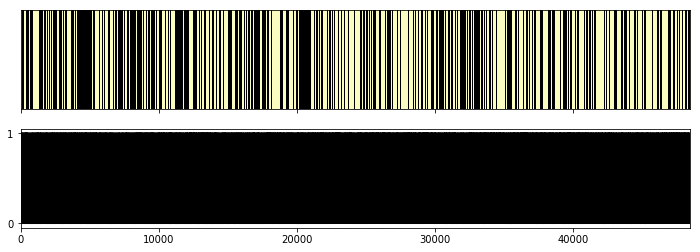

In [4]:
#- create a binary map of the A and T sites.
#- 0 if C,G  --  1 if A,T
AT_score = []
for i in record.seq:
    if i=='A' or i=='T':
        AT_score.append(1)
    else:
        AT_score.append(0)
    
    
#- create numpy arrays of the binary map and the positions along the DNA 
y = np.array(AT_score)
x = np.linspace(0,len(record.seq),len(record.seq))

#- Now we are going to plot the map two ways.
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)

#- first as a 1D histogram
#- the y[np.newaxis] bit is to get it into the shape
#- of a 2D image to pass on to imshow. 
ax1.imshow(y[np.newaxis], cmap="magma", aspect="auto")

#-  then we plot the map as a 1D linegraph
ax2.plot(x,y,'k')

#- this gets rid of a bit of whitespace, and sets the y tick marks
ax1.set_xlim(x[0], x[-1])
ax1.set_yticks([])
ax2.set_yticks([0,1])

Oh, so these are fairly uninformative to look at. While it's at least possible to see variations when the data are plotted as a histogram, the line graph is really something to look at. In both cases, I think it's difficult to see trends in the data when they are plotted this granularly. To get a another perspective, I'm going to window across the data and average within the span of the window.

(50, 48451)

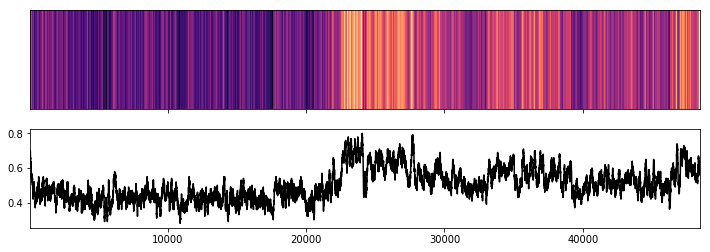

In [5]:
AT_score,AT_position = [],[]

#- here is the width of our rolling average.
window = 100

for i in range(len(record.seq)-window):
    
    #- center of the window, center of our averaging filter
    pos = int(i+window/2)
    
    #- grab a window-sized list of values centered at "pos"
    tmp_seq = record.seq[pos-int(window/2):pos+int(window/2)]
    
    #- count up all the As and Ts in that span.
    tmp_count = 0
    for j in tmp_seq:
        if j=='A' or j=='T':
            tmp_count+=1

    #- append the average        
    AT_score.append(tmp_count/float(window))
    AT_position.append(pos)
    

#- plotting
y = np.array(AT_score)
x = np.array(AT_position)
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
ax1.imshow(y[np.newaxis,:], cmap="magma", aspect="auto")
ax1.set_yticks([])
ax2.plot(x,y,"k")
ax1.set_xlim(x[0], x[-1])

So this looks substantially better. I think you can see the AT/GC skew quite easily in both plots. It begs the question, is there a "smart" amount of averaging to do or "right" size of window to use. Below lets plot a series of window values to see how the data look. 

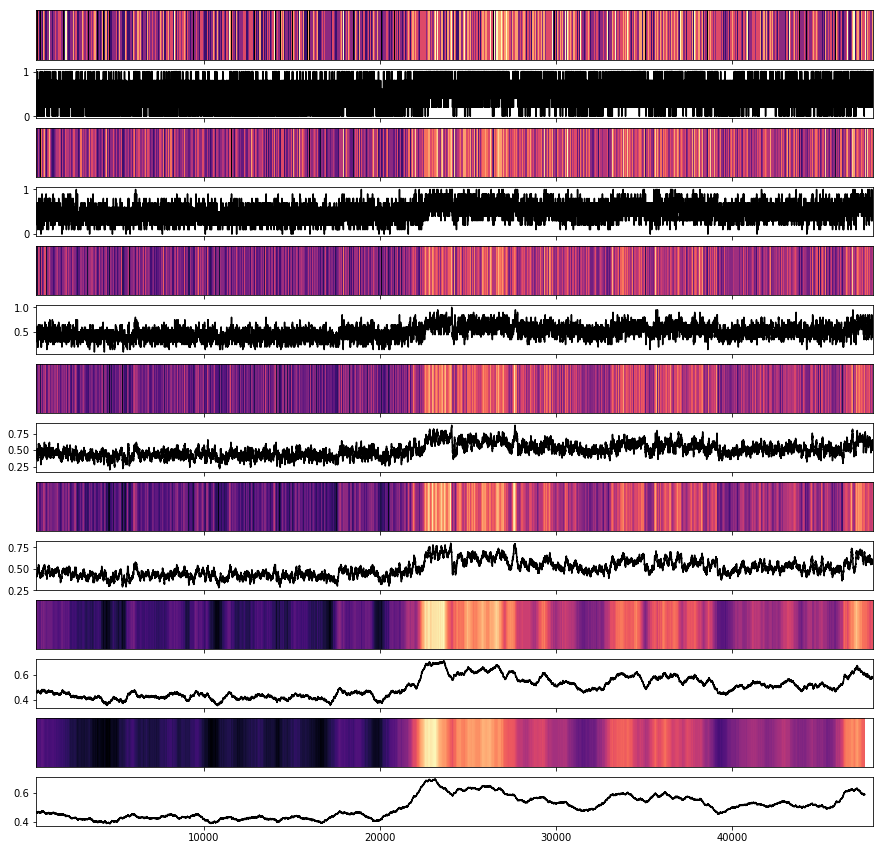

In [6]:
#- This is just what it looks like. a function to calculate a
#- a rolling average from the data given a window size.
def Rolling_average(Data, Window):
    avgX, avgY = [],[]
    for j in range(len(Data)-Window):
        avgX.append(int(j+Window/2))
        vals = Data[j:j+Window]
        avgY.append(sum(vals)/float(Window))
    return(avgX,avgY)

#- generate the AT density we will average over
AT_score = []
for i in record.seq:
    if i=='A' or i=='T':
        AT_score.append(1)
    else:
        AT_score.append(0)

#- rolling average over a range of window sizes.
windowlist = [5,10,20,50,100,500,1000]
               
fig, axes = plt.subplots(nrows=len(windowlist)*2, ncols=1, sharex = True, figsize=(15,15))
axlist = [i for i in axes.flat]

for i in range(int(len(axlist)/2)): 
    window = windowlist[i] 
    avg_AT_position,avg_AT_score = Rolling_average(AT_score, window)

    y = np.array(avg_AT_score)  
    x = np.array(avg_AT_position)
    
    axlist[i*2].imshow(y[np.newaxis,:], cmap="magma", aspect="auto")
    axlist[i*2].set_yticks([])    
    axlist[i*2+1].plot(y, 'k')
    axlist[i*2].set_xlim(x[0], x[-1])

So thats pretty nice. and I think for something like showing the general basepair bias of the molecule the larger windows do a better job of relating that fact. That said, if we wanted to compare binding data to a plot like this, I think we would want to match the resolution of our experiment to the size of the averaging window. In the end, the "right" average is likely to be the one that helps you understand your data and doesn't average out or average in correlated trends.

#### Site-specific binding I
To make this last point in a roundabout way, lets switch over to a slightly different question. Lets try to understand the interaction landscape between a site-specific DNA binding protein and lambda DNA. For this example, I am going to use EcoRI, which binds to the site 5'-GAATTC-3'. To get started I'm going to introduce a couple of definitions to help use parse the DNA sequence.


In [7]:
#-- This bit of code determines the number of 
#-- differences between two strings
def Seq_distance(str1, str2):
    distance = 0
    for ch1, ch2 in zip(str1, str2):
        if ch1 != ch2:
            distance += 1
    return distance

#-- This bit uses regular expressions to find all of the
#-- occurances of a particular sequence within another sequence.
import re
def Find_all_seq(string, substring):
    return [m.start() for m in re.finditer(substring, string)]



#- Below are two ways to use the above to find the EcoRI binding sites in Lambda DNA.
#- You can also use the Biopython find function, which we use later on in this notebook.
                            ##################
                            #####--NOTE--#####
                            ##################
#-- The sequence for EcoRI is symmetric, meaning it is read the same on both strands 
#-- If it was not, we would need to search for both the 5'->3' sequence and the 
#-- 3'->5' complement.


ref_seq = 'GAATTC'

#- We can use built in biopython functions to see how many instances of the sequence there are.
print("number of sites:  ",record.seq.count(ref_seq))


#- the Seq_distance snippet isn't really built for this but you can get it to do the job.
for i in range(len(record.seq)-len(ref_seq)):
    tmp_seq = record.seq[i:i+len(ref_seq)]
    if Seq_distance(ref_seq, tmp_seq)==0:
        print(i)

#- Alternatively, Find_all_seq seems more streamlined for this purpose
print(Find_all_seq(str(record.seq), ref_seq))

number of sites:   5
21225
26103
31746
39167
44971
[21225, 26103, 31746, 39167, 44971]


Okay, first lets use the `Seq_distance` function to calculate the similarity of each hexameric site in the lambda DNA to the EcoRI recognition sequence. 

(3, 48498)

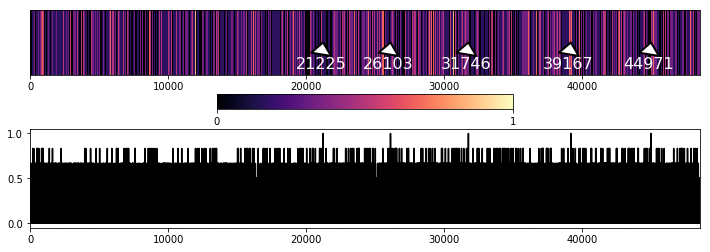

In [8]:
#- Lists for plotting
similarity,position = [],[]

#- EcoRI site
ref_seq = 'GAATTC'

for i in range(len(record.seq)-len(ref_seq)):
    position.append(int(i+len(ref_seq)/2))
    tmp_seq = record.seq[i:i+len(ref_seq)]
    similarity.append((len(ref_seq)-Seq_distance(ref_seq, tmp_seq))/len(ref_seq))
         


#- plotting
y = np.array(similarity)
y2 = np.array(Find_all_seq(str(record.seq), ref_seq))
x = np.array(position)
fig = plt.figure()
ax = fig.add_subplot(211)

#- here Im adding a colorbar for the fun of it.
cax = ax.imshow(y[np.newaxis,:], cmap="magma", aspect="auto")
cbar = fig.colorbar(cax, ticks=[0, 1],orientation='horizontal',pad=0.2)
ax.set_xlim(x[0], x[-1])
ax.set_yticks([])

#- here Im adding some arrows pointing to each EcoRI site, also for the fun of it
for i in Find_all_seq(str(record.seq), ref_seq):
    ax.annotate(str(i), xy=(i, 0), color="white", fontsize = 16, xytext=(i-2000, 0.4),
            arrowprops=dict(facecolor='white',lw=2,width = 10,headwidth=20))

#- annnnd here's a line plot.
ax2 = fig.add_subplot(212)
ax2.plot(x,y,'k')
ax2.set_xlim(x[0], x[-1])

So without the arrows, I dont think you would be able to pick out the sites at all. The 2D histogram is pretty terrible in this case. The line plot also looks ridiculous, but it is possible to tell where the true sites are... so there's that. What happens if we average like before, do you think it will become more obvious where the RE sites are?


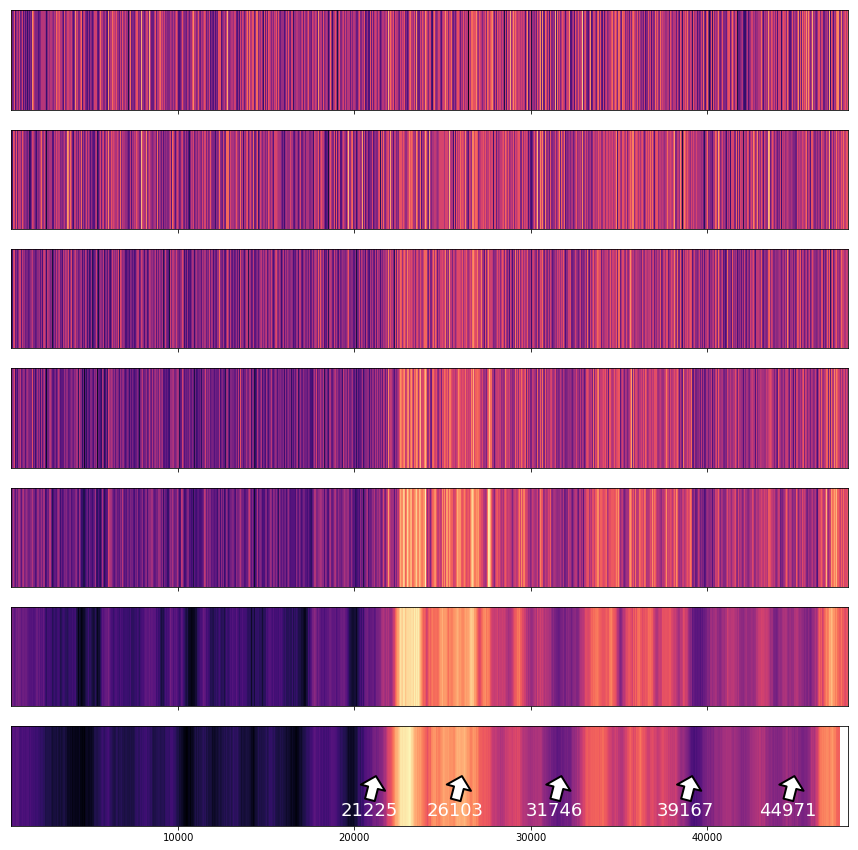

In [9]:
similarity,position = [],[]
ref_seq = 'GAATTC'
for i in range(len(record.seq)-len(ref_seq)):
    position.append(int(i+len(ref_seq)/2))
    tmp_seq = record.seq[i:i+len(ref_seq)]
    similarity.append((len(ref_seq)-Seq_distance(ref_seq, tmp_seq))/len(ref_seq))
         
        
#- This is just like above for the AT score plotting  
windowlist = [5,10,20,50,100,500,1000]            
fig, axes = plt.subplots(nrows=len(windowlist), ncols=1, sharex = True,figsize=(15,15))
axlist = [i for i in axes.flat]

for i in range(int(len(axlist))): 
    window = windowlist[i] 
    EcoRI_position,EcoRI_score = Rolling_average(similarity, window)
    y = np.array(EcoRI_score)  
    x = np.array(EcoRI_position)
    
    axlist[i].imshow(y[np.newaxis,:], cmap="magma", aspect="auto")
    axlist[i].set_yticks([])    
    axlist[i].set_xlim(x[0], x[-1])
    
#- Imma add them arrows again, but just on the last plot.
for i in Find_all_seq(str(record.seq), ref_seq):
    axlist[-1].annotate(str(i), xy=(i, 0), color="white", fontsize = 18, xytext=(i-2000, 0.4),
            arrowprops=dict(facecolor='white',lw=2,width = 10,headwidth=25))    
    
    

Whoa. This looks just like the AT plots above. If you think about it for a minute, the reason is obvious. We are averaging over areas which are most like the EcoRI binding site, which is 2/3 AT. If we switched it up to say the BamHI site, GGATCC, we should expect the opposite.

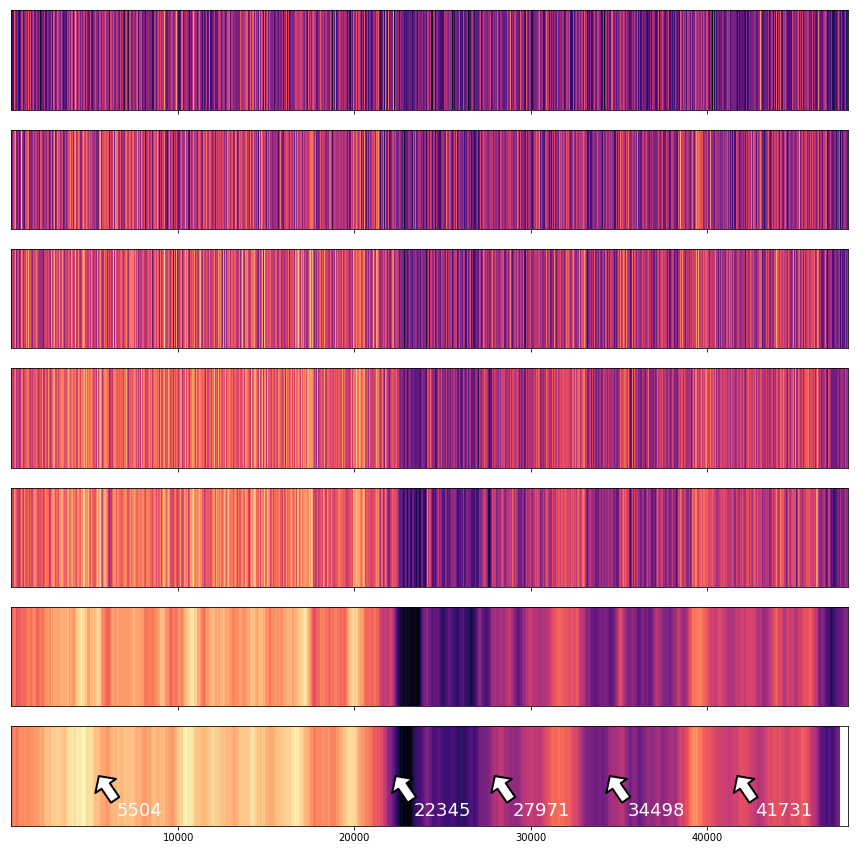

In [10]:
similarity,position = [],[]
ref_seq = 'GGATCC'
for i in range(len(record.seq)-len(ref_seq)):
    position.append(int(i+len(ref_seq)/2))
    tmp_seq = record.seq[i:i+len(ref_seq)]
    similarity.append((len(ref_seq)-Seq_distance(ref_seq, tmp_seq))/len(ref_seq))
          
windowlist = [5,10,20,50,100,500,1000]            
fig, axes = plt.subplots(nrows=len(windowlist), ncols=1, sharex = True,figsize=(15,15))
axlist = [i for i in axes.flat]

for i in range(int(len(axlist))): 
    window = windowlist[i] 
    BamHI_position,BamHI_score = Rolling_average(similarity, window)
    y = np.array(BamHI_score)  
    x = np.array(BamHI_position)
    
    axlist[i].imshow(y[np.newaxis,:], cmap="magma", aspect="auto")
    axlist[i].set_yticks([])    
    axlist[i].set_xlim(x[0], x[-1])
    
#- Imma add them arrows one more time!!
for i in Find_all_seq(str(record.seq), ref_seq):
    axlist[-1].annotate(str(i), xy=(i, 0), color="white", fontsize = 18, xytext=(i+1000, 0.4),
            arrowprops=dict(facecolor='white',lw=2,width = 10,headwidth=25))    


Alright, that's pretty much what we thought then. Its important to think about how averaging over some character of the DNA might lead to results that are less than informative or even just plain wrong. Its also worth noting that I think this might just the absolute worst way to visualize this kind of DNA feature.

#### Site-specific binding II
To make the above plots though, we made an assumption requiring perfect identity at each position. In reality proteins are often less stringent than that. We often think of binding sites relative to some ideal consensus sequence that is infered from looking to the frequency of interaction with varying DNA sequences. For the next bit of this notebook, we are going to generate a random consensus sequence, convert it into a sequence logo, and then map that interaction across lambda.

In order to get started I am going to generate a set of probabilities, or weights, for finding each base at each position in a protein's binding site. This set of probabilities is called a position weight matrix. 


In [11]:
import random as r
#- This little bit is a function that allows one to sample
#- items from a list based on a complementary list of probabilities
#- This function can also be used to pick moves in a kinetic monte carlo algorithm
def random_pick(some_list, probabilities):
    #- pick a uniform random number between 0 and 1
    x = r.uniform(0, 1)*sum(probabilities)
    cumulative_probability = 0.0
    #- find the individual P, such that x*sum(probabilities) is > P and < P+1
    for item, item_probability in zip(some_list, probabilities):
        #- update the probability
        cumulative_probability += item_probability
        #- test for selection
        if x < cumulative_probability: break
    return item 

#- The definition below creates a random position weight matrix for a given length of binding site
#- essentially a list of lists of exponentially random preferences for each base site
def Create_expo_PWM(length,scale = 1,Bases = ["G","A","C","T"]):
    PWM = []
    for i in range(length):
        PWM.append([r.expovariate(scale) for i in range(len(Bases))])
    return PWM

In [12]:
from Bio.Seq import Seq
from Bio import motifs

#- generate the PWM
probs = Create_expo_PWM(9)

#- hmmmmm, what are these
Bases = ["G","A","C","T"]
   
#- Now we are going to generate 10000 instances of binding sites that satisfy the 
#- probabilities in the PWM. These might be the result of a ChIP-seq experiment, for example.
instances = []
for i in range(10000):
    sequence = [random_pick(Bases,j) for j in probs]
    instances.append(Seq(''.join(sequence)))

#- Then from this list we are going to generate a binding motif using the biopython motifs module
m = motifs.create(instances)

In [13]:
#- Lets check on what we have made.
#- First we print out the consensus sequence given the 10000 provided sequences.
print(m.consensus)

#- Then this will spit out the frequency of occurances of each of the bases. 
print(m.counts)

#- the counts normalized to one for each position should in principle be the PWM for our
#- protein. However, a straight normalization would equally weight each base, in reality
#- bases are not equally represented in genomes. We would instead like to normalize
#- where we weigh each bases occurance against the likelyhood of bases in the genome of lambda
#- as it turns out lambda, despite the base location skew, is very balanced in terms of 
#- base occurance, so the result is actually about the same.

#- number of G or C in genome
CG= (record.seq.count("C")/len(record.seq))+(record.seq.count("G")/len(record.seq))
#- number of A or T in genome
AT = (record.seq.count("A")/len(record.seq))+(record.seq.count("T")/len(record.seq))

#- the motifs module can do this fancy normalizatino for us.
pwm = m.counts.normalize(pseudocounts={'A':AT, 'C': CG, 'G': CG, 'T': AT})

print(pwm)

ACACTTCTG
        0      1      2      3      4      5      6      7      8
A: 4513.00 326.00 4813.00 3012.00 1977.00 2084.00 1018.00 2345.00 1155.00
C: 126.00 5452.00 3651.00 6759.00 772.00 2872.00 6612.00 233.00 2834.00
G: 2093.00 654.00 650.00 145.00 2293.00 1252.00 1918.00 1100.00 4114.00
T: 3268.00 3568.00 886.00  84.00 4958.00 3792.00 452.00 6322.00 1897.00

        0      1      2      3      4      5      6      7      8
A:   0.45   0.03   0.48   0.30   0.20   0.21   0.10   0.23   0.12
C:   0.01   0.55   0.37   0.68   0.08   0.29   0.66   0.02   0.28
G:   0.21   0.07   0.07   0.01   0.23   0.13   0.19   0.11   0.41
T:   0.33   0.36   0.09   0.01   0.50   0.38   0.05   0.63   0.19



The consensus is interesting, but because there are many reasons why it might be an oversimplified look at the binding interaction. Another option is to just represent the binding site as the position weight matrix, where both the strength of selection and identity at each postion are represented. To do that we can use a sequence logo, see [the weblogo website](http://weblogo.threeplusone.com/). You've probably encountered these before, and I highly recommend reading about how they are made.


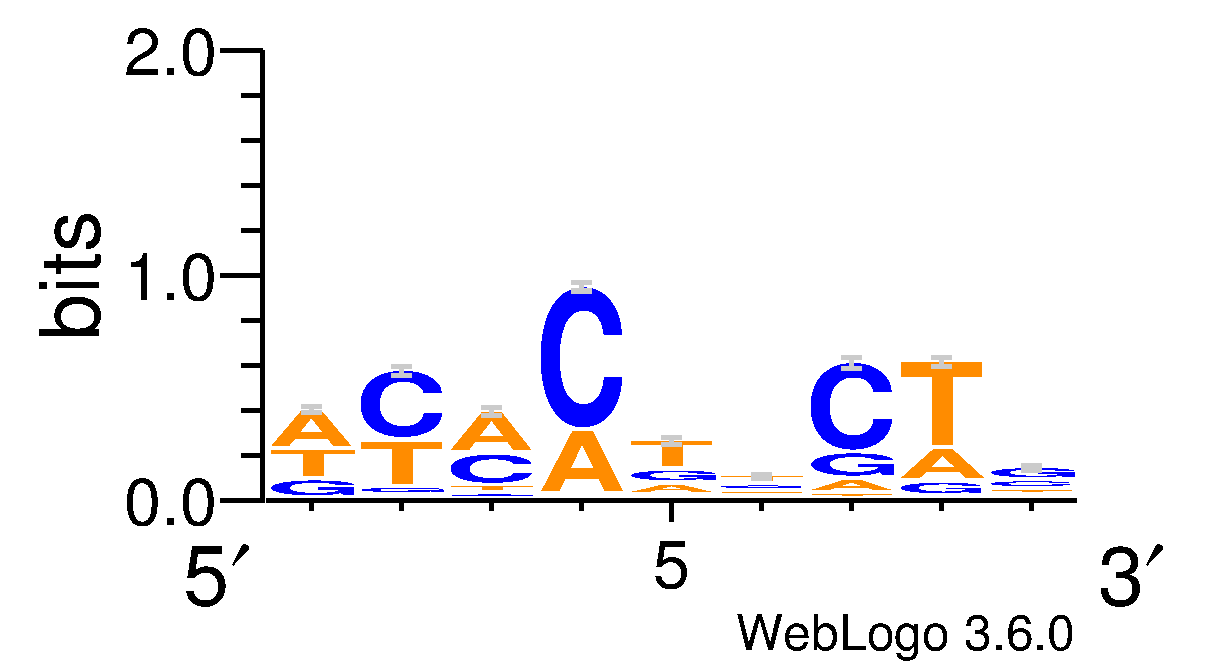

In [14]:
#- Im not sure if there is a way to do this differently, 
#- but it seemms like the only way to show the logo is to have it the function 
#- spit out an image in the folder you are running this notebook in, and
#- then open it up as an image.
m.weblogo('DNA_mapping_extras/LOGO.png',format='png_print')
from IPython.display import Image
Image('DNA_mapping_extras/LOGO.png', width = 600)

Its really quite interesting to how the binding sites turn out, given the way we are generating them. 

Okay, now we want to map the interaction of our hypothetical protein, which interacts with DNA acording to the PWM and sequence logo we have determined above, aginst the lambda phage genome. 

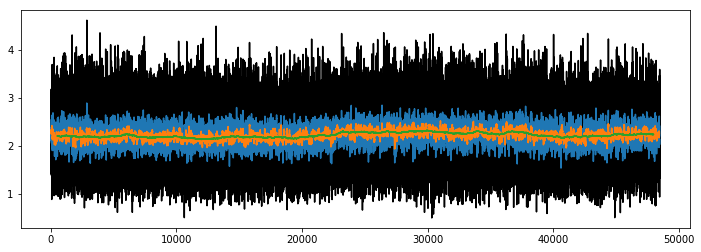

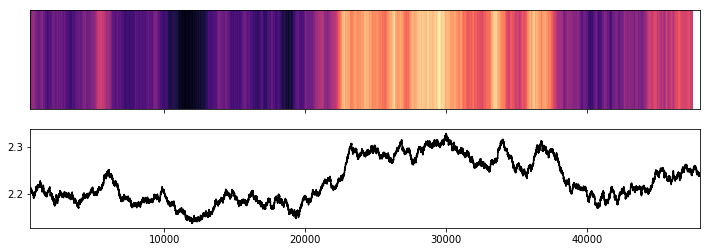

In [15]:
position_score,position = [],[]
seq_len = len(m.consensus)

#- below is similar to our sequence compare function above, except now
#- I am scoring each position in the sequence as the score from the PWM.
for i in range(len(record.seq)-seq_len):
    position.append(int(i+seq_len/2))
    tmp_seq = record.seq[i:i+seq_len]
    
    #- initialize the score
    tmp_score = 0
    
    for j in range(seq_len):
        #- tmp_seq[j] is the base, which we use to key the pwm dictionary
        #- j is the position in the sequence
        tmp_score+=pwm[tmp_seq[j]][j]
    position_score.append(tmp_score)
    
#- plotting the score and three rolling averages on top of each other
plt.plot(position, position_score,'k')
for i in [10,50,1000]:
    x,y = Rolling_average(position_score, i)
    plt.plot(x,y)
    
#- plotting in the way we were doing in the previous section
y = np.array(y)  
x = np.array(x)

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
ax1.imshow(y[np.newaxis,:], cmap="magma", aspect="auto")
ax1.set_yticks([])
ax1.set_xlim(x[0], x[-1])
ax2.plot(x,y,"k")

It is an exercise for a different lesson, but it would be nice to understand how an interaction profile like this would manifest in an experiment. How would things like frequency of binding, lifetime, and diffusion coefficents look for this profile? 

#### The Chi site and the E. coli genome
Fot the last example, we are going to look at the Chi sequence in E. coli (Chi stands for crossover hotspot instigator). The chi sequence is recognized by the RecBCD resection machine as part of DNA repair, it is overrepresented in the E. coli genome, and has an interesting distribution relative to replication landmarks. Here we are going to read in the entire E. coli genome from the NCBI nucleotide database, and count the chi sites. Then I will plot them around the coli genome as well as plotting the location of the replication origin and terminator using biopython genome diagram.

In [16]:
from Bio import Entrez
#- you should put in your email
Entrez.email='SyEugene.Redding@ucsf.edu'
#- The acsension number for E. Coli K12 strain I am using is CP014225.1, there are many others
coli = Entrez.efetch(db="nucleotide",rettype="gb",id="CP014225.1")
record = SeqIO.read(coli, "genbank")

In [17]:
#- In this case the sequence is not symmetric so we have a 
#- forward and a reverse sequence we are looking for.
Chi_seq_forward = "GCTGGTGG"
Chi_seq_reverse = "CCACCAGC"

#- lets count them both up
print("number of sites:  ",record.seq.count(Chi_seq_forward))
print("number of sites:  ",record.seq.count(Chi_seq_reverse))

#- and also calculate the number we would expect from random
#- note the 2 acounts for top and bottom strands.
print("\nfrequency of random 8mer:  ",2*int((len(record)/(4**8))))

number of sites:   501
number of sites:   510

frequency of random 8mer:   142


So there is almost 10 times too many of these sites... curious, we'll plot them on the genome momentarity, but first lets get the replication sites. I'm going to pull the origin sequence from NCBI. _It is worth noting, below is maybe to most roundabout way of finding the origin in the genome. A faster way might just look through a list of annotated features._ 

In [18]:
ori = Entrez.efetch(db="nucleotide",rettype="gb",id="K01789.1")
record_ori = SeqIO.read(ori, "genbank")
#- lets have a look at it
print(record_ori.seq)
#- And then use the built in find function to locate it.
record.seq.find(record_ori.seq)

GATCCTAGGTATTAAAAAGAAGATCTATTTATTTAGGAGATCTGTTCTATTGTGATCTCTTATTAGGATCGCACTGCCCTGTGGATAACAAGGATCCGGCTTTTAAGATCAACAACCTGGAAAGGATCATTAACTGTGAATGATCGGTGATCCTGGACCGTATAAGCTGGGATCAGAATGAGGGGTTATACACAACTCAAAAACTGAACAACAGTTGTTCTTTGGATAACTACCGGTTGATCCAAGCTTCCTGACAGAGTTATCCACAGTAGATCGCACGATCTGTATACTTATTTGAGTAAATTAACCCACGATCCCAGCCATTCTTCTGCCGGATCTTCCGGAATGTCGTGATCAAGAATGTTGATCTTCAGTGTTTCGCCTGTCTGTTTTGCACCGGAATTTTTGAGTTCTGCCTCGAG


-1

The -1, means that there is no matching sequence in the coli genome sequence that we have (the index position went all the way around to the end, i.e. -1 in python counting). Thats because the origin I pulled from NCBI is a consensus origin. In order to find the origin on our sequence, we should look through our genome and find the location that the consensus best aligns to. To do this against the entire genome would take a fair amount of time, and we would likely run into some memory issues that are not really the topic of this notebook. So instead, since I have a pretty good idea where the origin is I'm going to make it easy on us. _If you wanted to figure out the general vacinity of the sequence a first pass might have you search for a few substrings, but I'll leave that to you._

In [19]:
from Bio import pairwise2
#- I think the origin is in the span 2122819 -to- 2123512
#- The integer parameters at the end of the call to align are
#-     Identical characters score,
#-     non-identical character penalty,
#-     penalty for opening a gap
#-     penalty for extending a gap
alignments = pairwise2.align.globalms(record.seq[2122819:2123512], record_ori.seq, 2, -1, -5, -1)

#- The outputs from pairwise2 are kind of awful to look at in the notebook for 
#- larger sequences, below is just some formatting to make it easier to see the alignment.
seq_A = alignments[0][0]
seq_B = alignments[0][1]
line_size = 80
for i in range(int(len(seq_A)/line_size)+1):
    temp_seq_A = seq_A[i*line_size:(i+1)*line_size]
    temp_seq_B = seq_B[i*line_size:(i+1)*line_size]
    temp_compare = []
    for ch1, ch2 in zip(temp_seq_A, temp_seq_B):
        if ch1 != ch2:
            temp_compare.append("*")
        else:
            temp_compare.append("|")

    
    
    print(seq_A[i*line_size:(i+1)*line_size])
    print(''.join(temp_compare))
    print(seq_B[i*line_size:(i+1)*line_size])
    print("\n")

TCCGGATAAAACATGGTGATTGCCTCGCATAACGCGGTATGAAAATGGATTGAAGCCCGGGCCGTGGATTCTACTCAACT
********************************************************************************
--------------------------------------------------------------------------------


TTGTCGGCTTGAGAAAGACCTGGGATCCTGGGTATTAAAAAGAAGATCTATTTATTTAG-AGATCTGTTCTATTGTGATC
***********************||||||*|||||||||||||||||||||||||||||*||||||||||||||||||||
-----------------------GATCCTAGGTATTAAAAAGAAGATCTATTTATTTAGGAGATCTGTTCTATTGTGATC


TCTTATTAGGATCGCACTGCCCTGTGGATAACAAGGATCCGGCTTTTAAGATCAACAACCTGGAAAGGATCATTAACTGT
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
TCTTATTAGGATCGCACTGCCCTGTGGATAACAAGGATCCGGCTTTTAAGATCAACAACCTGGAAAGGATCATTAACTGT


GAATGATCGGTGATCCTGGACCGTATAAGCTGGGATCAGAATGAGGGGTTATACACAACTCAAAAACTGAACAACAGTTG
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
GAATGATCGGTGATCCTGGACCGTATAAGCTGGGATCAGAATGAGGGGTTATACACAACTCAAAAACTGAACAACAGTTG


TTCTTTGGATAACTACCGGT

You can see now that the reason the `find` function failed is due to those two mismatches in the sequence. Using the output from above we can now define the span of the origin in the genome by searching for the locations of the start and end sites, avoiding the mismatches.

In [20]:
ori_span = [record.seq.find("GATCCTGGGTATTAAAAAGAAGATCTAT"),
           record.seq.find("TTTATCGATAGCCCCACAAAAGGTGTCA")]
print(ori_span)

[2122922, 2123343]


Now we are going to locate the termination sites. I pulled all of the Ter and pseudo Ter sequences from http://www.ecogene.org/old/topic.php?topic_id=228

In [21]:
from Bio.Seq import Seq

TerA = Seq("AATTAGTATGTTGTAACTAAAGT").reverse_complement()
TerB = Seq("AATAAGTATGTTGTAACTAAAGT")
TerC = Seq("ATATAGGATGTTGTAACTAATAT")
TerD = Seq("CATTAGTATGTTGTAACTAAATG").reverse_complement()
pTerE = Seq("TTAAAGTATGTTGTAACTAAGCA").reverse_complement()
pTerF = Seq("CCTTCGTATGTTGTAACGACGAT")
TerG = Seq("GTCAAGGATGTTGTAACTAACCA")
TerH = Seq("CGATCGTATGTTGTAACTATCTC").reverse_complement()
TerI = Seq("AACATGGAAGTTGTAACTAACCG").reverse_complement()
pTerJ = Seq("ACGCAGTAAGTTGTAACTAATGC")
pTerK = Seq("CGATTGAGAGTTGTAATGAAGTC")
pTerL = Seq("GCACTGGGTGTTGTAATGACGCA")
pTerY = Seq("TATGGGTACGTTGTAATTAGGGA").reverse_complement()
pTerZ = Seq("TACCCGCAGGTTGTAACGAGAGC").reverse_complement()


# - you can map all of the Ter sites if you want, but the most common sites
# - for replication termination are TerA, TerB, TerC, and Im including TerD for obvious reasons
Ter_list = [TerA,TerB,TerC,TerD]   #,pTerE,pTerF,TerG,TerH,TerI,pTerJ,pTerK,pTerL,pTerY,pTerZ]
Ter_name_list = ["TerA","TerB","TerC","TerD"] #,"pTerE","pTerF","TerG", "TerH","TerI","pTerJ","pTerK","pTerL","pTerY","pTerZ"]

In [22]:
for i in range(len(Ter_list)):
    span = [record.seq.find(Ter_list[i]),record.seq.find(Ter_list[i])+len(Ter_list[i])]
    print(span)

[4180668, 4180691]
[4523149, 4523172]
[4448080, 4448103]
[4118450, 4118473]


Now I am going to plot the whole mess. __Importantly, I am going to make a distinction between chi sites in the forward and reverse orientations by plotting them as different colors.__

In [23]:
from reportlab.lib import colors
from Bio.Graphics import GenomeDiagram
from Bio.SeqFeature import SeqFeature, FeatureLocation

#- initialize the diagram (i.e. plt.figure()).
diagram = GenomeDiagram.Diagram(record.id)
#- a track is a place to put features, like ORFs or chi sites. 
track = diagram.new_track(1)
#- Here is an empty list of features that we are going to add to below
features = track.new_set()

#- add in the Chi sites
for site, color in [(Chi_seq_forward,colors.magenta),(Chi_seq_reverse,colors.green)]:
    #- our old friend, find all the sites.
    indices = Find_all_seq(str(record.seq), site)
    for index in indices:
        #- for each chi site location, append to the features list.
        feature = SeqFeature(FeatureLocation(index,index+len(site)))
        features.add_feature(feature, color=color)
        
#- Add the Origin
feature = SeqFeature(FeatureLocation(ori_span[0], ori_span[1]))
features.add_feature(feature,name="Origin", color=colors.orange,
                                   label=True, label_size = 25,
                                   label_color=colors.black)
#- Now the Ter sites
for i in range(len(Ter_list)):
    feature = SeqFeature(FeatureLocation(record.seq.find(Ter_list[i]), record.seq.find(Ter_list[i])+len(Ter_list[i])))
    features.add_feature(feature,name=Ter_name_list[i], color=colors.orange,
                                       label=True, label_size = 25,
                                       label_color=colors.black)

#- here is the output. we set it to a circle because coli is a circle.     
diagram.draw(format="circular", circular=True, start=0, end=len(record), circle_core = .4)
diagram.write("DNA_mapping_extras/Chi_sites.png", "PNG")

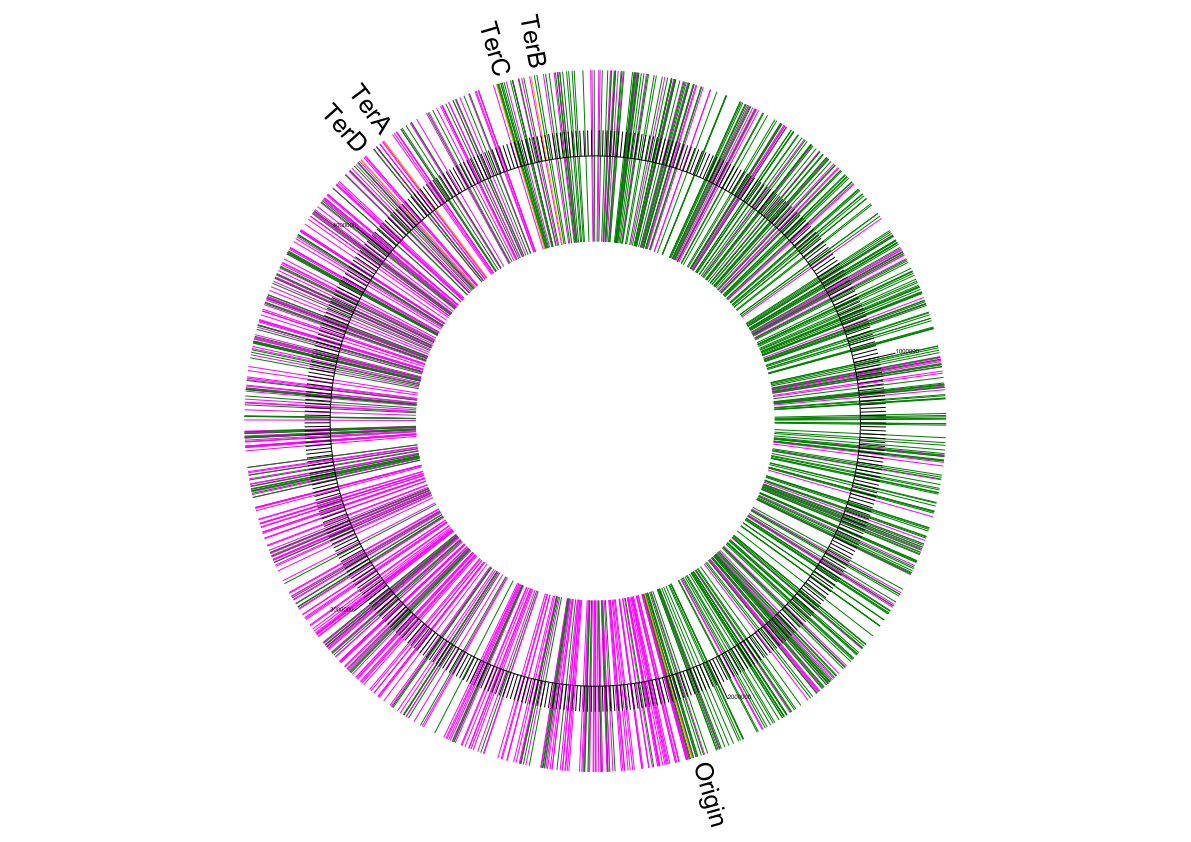

In [24]:
Image('DNA_mapping_extras/Chi_sites.png', width = 600)

It's pretty striking I think. I wonder if you can tell which is the most used termination site? The biology of why this asymmetry exists is neat, and some info about it can be found on the webpage I got the Ter sequences from, or, you know, in the lit-trich-traw. 
